In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from iso3166 import countries
import matplotlib.pyplot as plt
%matplotlib inline 

***
### Read FSP maps data

In [41]:
fsp = pd.read_csv('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/FSP_Maps/FSP_maps.csv', index_col=0)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Read country maps

**India**

In [3]:
indMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_IND.shp')

In [4]:
# Get Uttar Pradesh and Bihar states
indMapStates = indMap[(indMap['NAME_1'] == 'Uttar Pradesh') | (indMap['NAME_1'] == 'Bihar')]

**Kenya**

In [5]:
kenMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_KEN.shp')

**Uganda**

In [6]:
ugaMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_UGA.shp')

**Bangladesh**

In [7]:
bgdMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_BGD.shp')

**Nigeria**

In [8]:
ngaMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_NGA.shp')

**Tanzania**

In [9]:
tzaMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_TZA.shp')

**Lesotho**

In [10]:
lsoMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_LSO.shp')

Get the boundary of each country

In [11]:
# The shapely.ops module has a cascaded_union that finds the cumulative union of many objects
from shapely.ops import cascaded_union

In [12]:
indBoundary = gpd.GeoSeries(cascaded_union(indMapStates['geometry']))
indBoundary = gpd.GeoDataFrame(indBoundary).rename(columns={0: 'geometry'})
indBoundary['country'] = 'India'

kenBoundary = gpd.GeoSeries(cascaded_union(kenMap['geometry']))
kenBoundary = gpd.GeoDataFrame(kenBoundary).rename(columns={0: 'geometry'})
kenBoundary['country'] = 'Kenya'

ugaBoundary = gpd.GeoSeries(cascaded_union(ugaMap['geometry']))
ugaBoundary = gpd.GeoDataFrame(ugaBoundary).rename(columns={0: 'geometry'})
ugaBoundary['country'] = 'Uganda'

bgdBoundary = gpd.GeoSeries(cascaded_union(bgdMap['geometry']))
bgdBoundary = gpd.GeoDataFrame(bgdBoundary).rename(columns={0: 'geometry'})
bgdBoundary['country'] = 'Bangladesh'

ngaBoundary = gpd.GeoSeries(cascaded_union(ngaMap['geometry']))
ngaBoundary = gpd.GeoDataFrame(ngaBoundary).rename(columns={0: 'geometry'})
ngaBoundary['country'] = 'Nigeria'

tzaBoundary = gpd.GeoSeries(cascaded_union(tzaMap['geometry']))
tzaBoundary = gpd.GeoDataFrame(tzaBoundary).rename(columns={0: 'geometry'})
tzaBoundary['country'] = 'Tanzania'

lsoBoundary = gpd.GeoSeries(cascaded_union(lsoMap['geometry']))
lsoBoundary = gpd.GeoDataFrame(lsoBoundary).rename(columns={0: 'geometry'})
lsoBoundary['country'] = 'Lesotho'

boundaries = gpd.GeoDataFrame(pd.concat([indBoundary,kenBoundary,ugaBoundary,bgdBoundary,ngaBoundary,tzaBoundary,lsoBoundary]))

### Voronoi tessellation finite_polygons
Built a Voronoi tessellation from points

In [13]:
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point

In [14]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [15]:
def voronoi_tesellation_box(boundary,lng,lat):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    boundary : GeoDataFrame, 
        Geometry of the country.
    lng : GeoSeries, 
        Longitud values of points. 
    lat : GeoSeries, 
        Longitud values of points. 
    Returns
    -------
    voronoid : GeaoDataFrames
        Geometries of Voronoi regions.
    """
    # array with points coordinates
    points = np.zeros((lng.shape[0],2))
    points[:,0] = lng
    points[:,1] = lat

    # compute Voronoi tesselation
    vor = Voronoi(points)
    
    # Reconstruct infinite voronoi regions in a 2D diagram to finite regions.
    regions, vertices = voronoi_finite_polygons_2d(vor)
    
    # build box from country boundary
    xmin = boundary.bounds.minx[0]
    xmax = boundary.bounds.maxx[0]
    ymin = boundary.bounds.miny[0]
    ymax = boundary.bounds.maxy[0]

    box = Polygon([[xmin, ymin], [xmin, ymax], [xmax, ymax], [xmax, ymin]])

    voronoid = [] 
    for region in regions:
        polygon = vertices[region]
        # Clipping polygon
        poly = Polygon(polygon)
        voronoid.append(poly.intersection(box))
        
    voronoid = gpd.GeoDataFrame(geometry = voronoid)
    
    vor_lng = vor.points[:,0]
    vor_lat = vor.points[:,1]
    
    voronoid['lng'] = vor_lng
    voronoid['lat'] = vor_lat
    
    return voronoid    

In [16]:
fsp.head()

,id,sector,type,land_use,iso,country,lat,lng,year,name,color,type_id
0,0,Agriculture,Agro-dealers,Rural,IND,India,25.56872,84.67436,2014,NaN,#1f77b4,1
1,1,Agriculture,Agro-dealers,Rural,IND,India,26.91513,83.43577,2014,NaN,#1f77b4,1
2,2,Agriculture,Agro-dealers,Rural,IND,India,26.16912,84.04030,2014,NaN,#1f77b4,1
3,3,Agriculture,Agro-dealers,Rural,IND,India,26.67519,83.22662,2014,NaN,#1f77b4,1
4,4,Agriculture,Agro-dealers,Rural,IND,India,26.67521,83.22684,2014,NaN,#1f77b4,1


In [17]:
fsp['sector'].unique()

array(['Agriculture', 'Education', 'Finance', 'Health', 'Library'],
      dtype=object)

In [39]:
lng = fsp[(fsp['sector'] == 'Education') & (fsp['country'] == 'Uganda') & (fsp['type'] == 'Secondary Schools (Private)')]['lng']
lat = fsp[(fsp['sector'] == 'Education') & (fsp['country'] == 'Uganda') & (fsp['type'] == 'Secondary Schools (Private)')]['lat']
boundary = gpd.GeoDataFrame(boundaries[boundaries['country'] == 'Uganda']['geometry'])

In [42]:
lng = fsp[(fsp['sector'] == 'Finance') & (fsp['country'] == 'Lesotho') & (fsp['type'] == 'Atm')]['lng']
lat = fsp[(fsp['sector'] == 'Finance') & (fsp['country'] == 'Lesotho') & (fsp['type'] == 'Atm')]['lat']
boundary = gpd.GeoDataFrame(boundaries[boundaries['country'] == 'Lesotho']['geometry'])

In [43]:
voronoid = voronoi_tesellation_box(boundary,lng,lat)

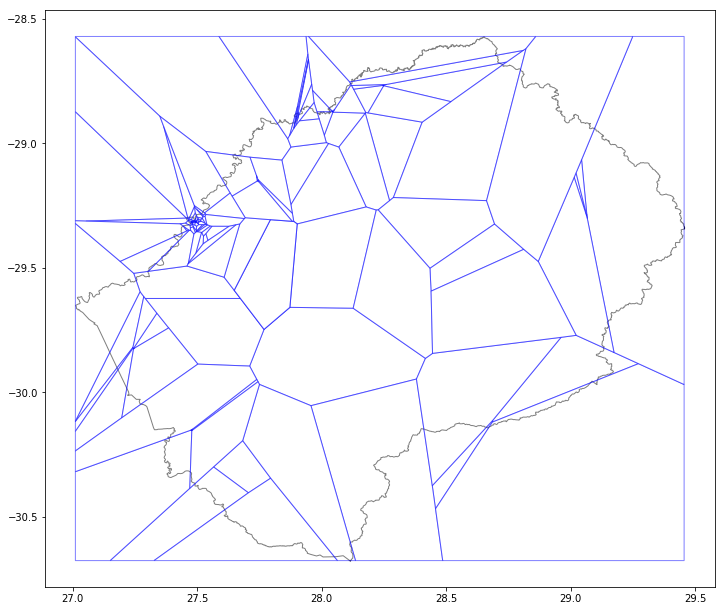

In [44]:
fig, ax = plt.subplots(figsize=[12,12])
ax.set_aspect('equal')

boundary.plot(ax=ax, color='white', edgecolor='black')
voronoid.plot(ax=ax, color='white', edgecolor='b', alpha=0.5)

In [45]:
# Coordinate reference system : WGS84
boundary.crs = {'init': 'epsg:4326'}
voronoid.crs = {'init': 'epsg:4326'}

**Intersect voronoid with boundary**

In [46]:
def spatial_overlays(df1, df2):
    '''Compute overlay intersection of two 
        GeoPandasDataFrames df1 and df2
    '''
    df1 = df1.copy()
    df2 = df2.copy()
    df1['geometry'] = df1.geometry.buffer(0)
    df2['geometry'] = df2.geometry.buffer(0)

    # Spatial Index to create intersections
    spatial_index = df2.sindex
    df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
    df1['histreg']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
    pairs = df1['histreg'].to_dict()
    nei = []
    for i,j in pairs.items():
        for k in j:
            nei.append([i,k])
        
    pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
    pairs = pairs.merge(df1, left_on='idx1', right_index=True)
    pairs = pairs.merge(df2, left_on='idx2', right_index=True, suffixes=['_1','_2'])
    pairs['Intersection'] = pairs.apply(lambda x: (x['geometry_1'].intersection(x['geometry_2'])).buffer(0), axis=1)
    pairs = gpd.GeoDataFrame(pairs, columns=pairs.columns, crs=df1.crs)
    cols = pairs.columns.tolist()
    cols.remove('geometry_1')
    cols.remove('geometry_2')
    cols.remove('histreg')
    cols.remove('bbox')
    cols.remove('Intersection')
    dfinter = pairs[cols+['Intersection']].copy()
    dfinter.rename(columns={'Intersection':'geometry'}, inplace=True)
    dfinter = gpd.GeoDataFrame(dfinter, columns=dfinter.columns, crs=pairs.crs)
    dfinter = dfinter.loc[dfinter.geometry.is_empty==False]
    dfinter.drop(['idx1','idx2'], axis=1, inplace=True)
    return dfinter

In [47]:
# Remove GeometryCollection and replace it by a nearby Polygon
ind = voronoid[voronoid['geometry'].type == 'GeometryCollection'].index
if len(voronoid[voronoid['geometry'].type == 'GeometryCollection']) > 0:
    for p in range(len(voronoid[voronoid['geometry'].type == 'GeometryCollection'])):
        voronoid.geometry.iloc[ind[p]] = voronoid.geometry.iloc[ind[p]-1]        

In [48]:
%%time
voronoid= spatial_overlays(voronoid, boundary)
#voronoid=gpd.overlay(gpd.GeoDataFrame(voronoid), boundary, how='intersection')

CPU times: user 1.55 s, sys: 14.9 ms, total: 1.57 s
Wall time: 1.61 s


After the intersection a single voronoid can be divided into a multiple polygons as it intersects with different parts of the boundary.

We split the MultiPolygons and we take the Polygon thet intersect with the corresponding point.

In [49]:
# Convert MultiPolygons into Polygons
#def convert_MultiPolygon_Polygon(voronoid):
    # split MultiPolygons into a Polygon
#    for i in range(len(voronoid)):
#        if voronoid.geometry.iloc[i].type == 'MultiPolygon':
#            point = Point(voronoid.lng.iloc[i],voronoid.lat.iloc[i])
#            for j in range(len(list(voro.geometry.iloc[i]))):
#                poly = list(voronoid.geometry.iloc[i])[j]
#                #Only take the polygon that intersects with the corresponding point
#                if poly.contains(point):
#                    polygon = poly
#            voronoid.geometry.iloc[i] = polygon
    
#    return voronoid

In [50]:
#voronoid = convert_MultiPolygon_Polygon(voronoid)

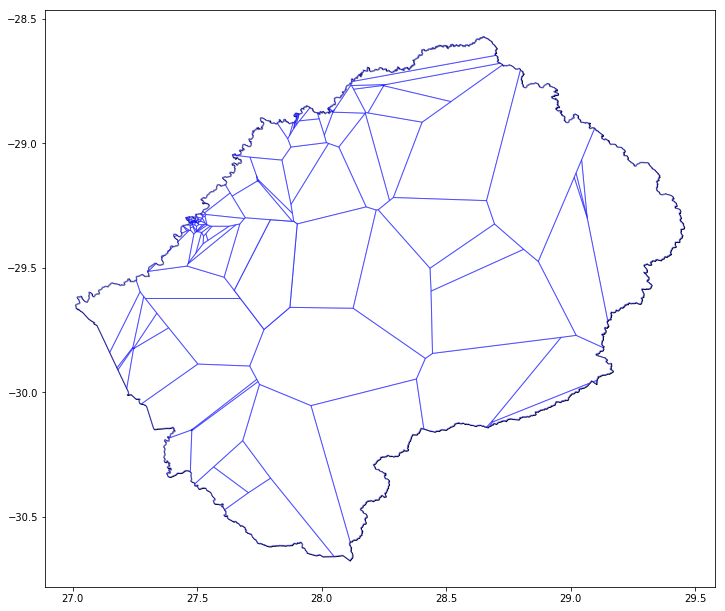

In [51]:
fig, ax = plt.subplots(figsize=[12,12])
ax.set_aspect('equal')

boundary.plot(ax=ax, color='white', edgecolor='black')
voronoid.plot(ax=ax, color='white', edgecolor='b', alpha=0.5)

### Nearest neighbour distance map

In [52]:
from scipy.spatial import cKDTree

In [53]:
def distances_map_cKDTree(boundary, pixel_size, points):
    
    xmin = int(np.floor(boundary.bounds.minx[0]))
    xmax = int(np.ceil(boundary.bounds.maxx[0]))
    ymin = int(np.floor(boundary.bounds.miny[0]))
    ymax = int(np.ceil(boundary.bounds.maxy[0]))
    
    x = np.linspace(xmin, xmax, int((xmax-xmin)/pixel_size)+1)
    y = np.linspace(ymin, ymax, int((ymax-ymin)/pixel_size)+1)
    
    tree = cKDTree(points)
    
    image = np.zeros((len(y),len(x)))
    
    for i in range(len(x)):
        for j in range(len(y)):
            image[j,i] = tree.query([x[i],y[j]])[0]
    return image

In [54]:
points = np.zeros((lng.shape[0],2))
points[:,0] = lng
points[:,1] = lat

In [55]:
distance = distances_map_cKDTree(boundary, 0.025, points)

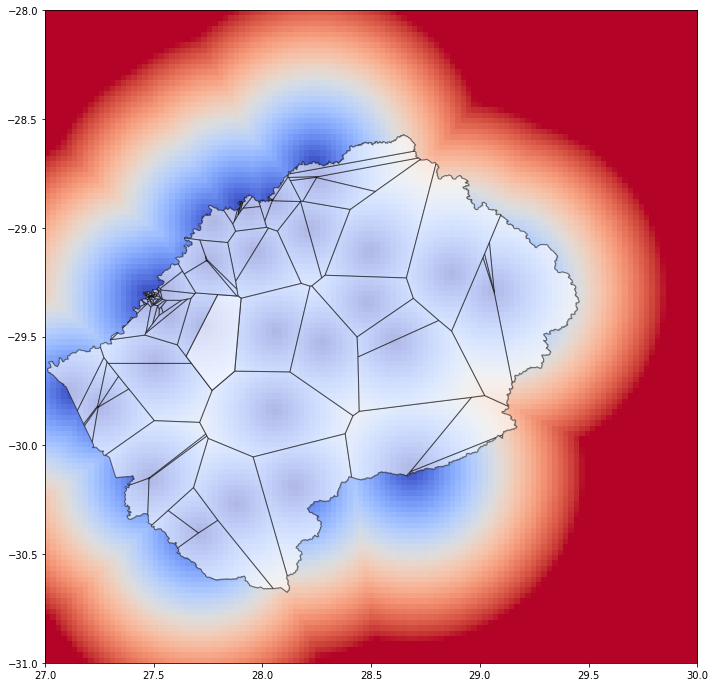

In [56]:
xmin = int(np.floor(boundary.bounds.minx[0]))
xmax = int(np.ceil(boundary.bounds.maxx[0]))
ymin = int(np.floor(boundary.bounds.miny[0]))
ymax = int(np.ceil(boundary.bounds.maxy[0]))

fig, ax = plt.subplots(figsize=[12,12])

ax.imshow(distance, origin = 'lower', extent=[xmin,xmax,ymin,ymax], vmax=0.8, cmap='coolwarm')
boundary.plot(ax=ax, color='white', edgecolor='black', alpha=0.2)
voronoid.plot(ax=ax, color='white', edgecolor='k', alpha=0.5)

### Saving raster data
We use raterio to save the grid as a GeoTIFF file

In [57]:
import rasterio

To save the coordinates we use the `from_origin` function in the `rasterio.transform` module.

Note, in the from_origin() method, west should be a value from -180 to 180 (not 0-360).

In [58]:
pixel_size = 0.025
west = int(np.floor(boundary.bounds.minx[0])) - pixel_size/2
north = int(np.ceil(boundary.bounds.maxy[0])) - pixel_size/2

trans = rasterio.transform.from_origin(west, north, pixel_size, pixel_size)

To save the array along with georeferencing information to a new raster data file, call `rasterio.open()` with a path to the new file to be created, `'w'` to specify writing mode, and several keyword arguments.

In [59]:
!mkdir ./data
dataset = rasterio.open('./data/distance.tif', 'w', driver='GTiff',
                        height=distance.shape[0], width=distance.shape[1],
                        count=1, dtype='float64',
                        crs='EPSG:4326', transform=trans)

Reverse the order of elements along the y-axis

In [60]:
distance = np.flip(distance,axis=0)

To save the grid, call the new dataset’s `write()` method with the grid and target band number as arguments.

In [61]:
dataset.write(distance, 1)

and then call the `close()` method to sync data to disk and finish.

In [62]:
dataset.close()

### Zonal statistics

In [63]:
from rasterstats import zonal_stats

In [64]:
with rasterio.open('./data/distance.tif') as dataset:
    myData=dataset.read(1)

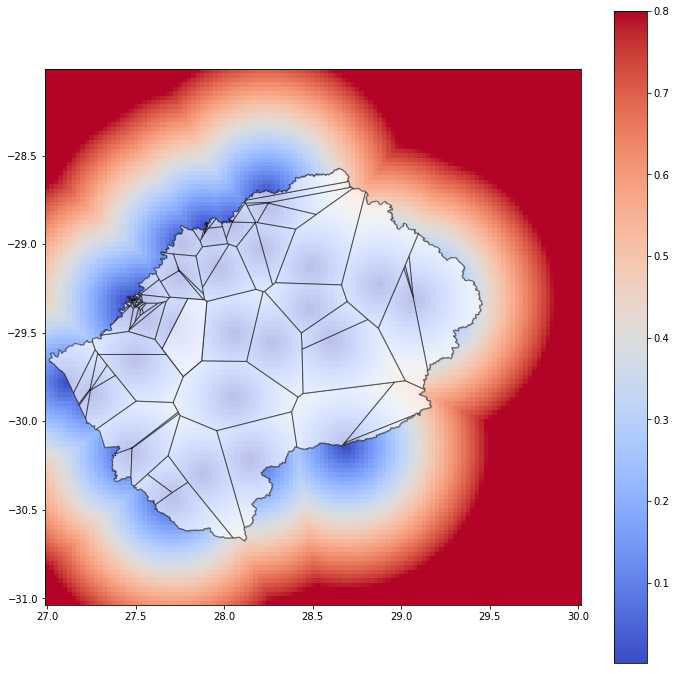

In [65]:
fig, ax = plt.subplots(figsize=[12,12])

im = ax.imshow(myData, extent=[dataset.bounds[0],dataset.bounds[2],dataset.bounds[1],dataset.bounds[3]], vmax=0.8, cmap='coolwarm')
boundary.plot(ax=ax, color='white', edgecolor='black', alpha=0.3)
voronoid.plot(ax=ax, color='white', edgecolor='k', alpha=0.5)

fig.colorbar(im, ax=ax)

In [66]:
zs = zonal_stats(voronoid, './data/distance.tif',  all_touched=True)
zs = gpd.GeoDataFrame(zs)
voronoid_zs = voronoid.join(zs)
voronoid_zs.head()

/anaconda3/lib/python3.6/site-packages/rasterstats/main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/anaconda3/lib/python3.6/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/anaconda3/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/anaconda3/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)


,lng,lat,geometry,count,max,mean,min
0,27.49570,-29.31630,POLYGON ((27.49272851050197 -29.31823635157149...,1,0.013066,0.013066,0.013066
1,28.04890,-28.87584,POLYGON ((28.04555364579606 -28.87475664221825...,35,0.126874,0.072142,0.001384
2,28.04896,-28.87388,POLYGON ((28.05232719143566 -28.86360021410596...,22,0.132972,0.088204,0.021485
3,27.24438,-29.82287,POLYGON ((27.24533572466245 -29.82398483507094...,1,0.022334,0.022334,0.022334
4,28.20943,-29.00093,POLYGON ((28.18622331371957 -28.87769245811981...,91,0.212109,0.117011,0.009128


Save voronoid

In [67]:
#voronoid_zs.to_file(driver='ESRI Shapefile',filename='./data/voronoid.shp')

In [68]:
import matplotlib as mpl
import matplotlib.cm as cm
# The shapely.ops module has a cascaded_union that finds the cumulative union of many objects
from shapely.ops import cascaded_union

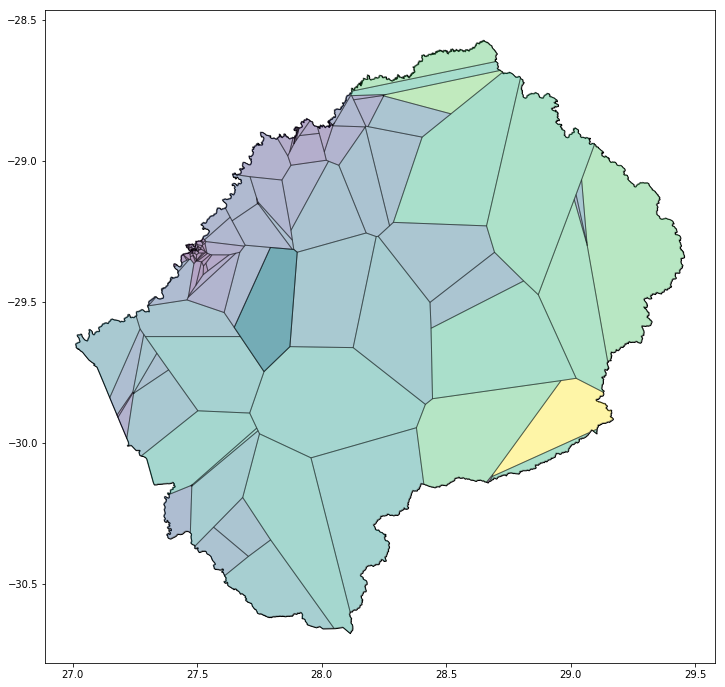

In [69]:
# find min/max values for normalization
minima = voronoid_zs['mean'].min()
maxima = voronoid_zs['mean'].max()

# normalize chosen colormap
norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

fig, ax = plt.subplots(figsize=[12,12])

boundary.plot(ax=ax, color='white', edgecolor='black')

for i in range(len(voronoid_zs)):
    if (np.isnan(voronoid_zs['count'].iloc[i]) == False):
        polygon = voronoid_zs['geometry'].iloc[i]
        if voronoid_zs.geometry.iloc[i].type == 'Polygon':
            x, y = polygon.exterior.coords.xy
            ax.fill(x, y, facecolor=mapper.to_rgba(voronoid_zs['mean'].iloc[i]), edgecolor='k', zorder=1, alpha=0.4)
        else:
            point = Point(voronoid_zs.lng.iloc[i],voronoid_zs.lat.iloc[i])
            for j in range(len(list(voronoid_zs.geometry.iloc[i]))):
                polygon = list(voronoid_zs.geometry.iloc[i])[j]
                x, y = polygon.exterior.coords.xy
                ax.fill(x, y, facecolor=mapper.to_rgba(voronoid_zs['mean'].iloc[i]), edgecolor='k', zorder=1, alpha=0.4)

### Voronoid table with the same ID as  point table

Merge voronoid table with some FSP maps info

In [ ]:
voronoid = pd.read_csv('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/FSP_Maps/FSP_voronoids.csv', index_col=0)

In [ ]:
voronoid.head()

In [ ]:
fsp = pd.read_csv('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/FSP_Maps/FSP_maps.csv', index_col=0)

In [ ]:
fsp.head()

In [ ]:
df = fsp[['id','sector','iso']]

In [ ]:
voronoid = pd.merge(voronoid, df, how='left', on='id')

In [ ]:
voronoid.head()

In [ ]:
voronoid['sector'].unique()

Split table in two 

In [ ]:
voronoid1 = voronoid[(voronoid['sector'] == 'Agriculture') | (voronoid['sector'] == 'Education')]

In [ ]:
voronoid2 = voronoid[(voronoid['sector'] == 'Finance') | (voronoid['sector'] == 'Health') | (voronoid['sector'] == 'Library')]

In [ ]:
voronoid1.to_csv('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/FSP_Maps/FSP_voronoid_1.csv')

In [ ]:
voronoid2.to_csv('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/FSP_Maps/FSP_voronoid_2.csv')